Video: C:\Users\flow\Desktop\今さんデータ\straightball.mp4
Resolution: 1024.0x1024.0
Total Frames: 1001.0
FPS: 30.00003000003
DPI: 1024
video_directory: C:\Users\flow\Desktop\bubble_rasing_result\straightball
C:\Users\flow\Desktop\bubble_rasing_result\straightball\original
C:\Users\flow\Desktop\bubble_rasing_result\straightball\gray
C:\Users\flow\Desktop\bubble_rasing_result\straightball\binary
C:\Users\flow\Desktop\bubble_rasing_result\straightball\contours
C:\Users\flow\Desktop\bubble_rasing_result\straightball\angles
Processing frame 0/1001.0


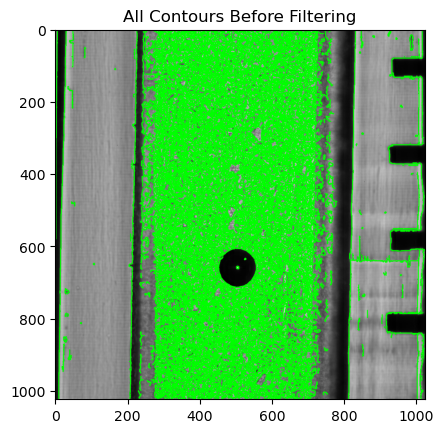

Processing frame 1/1001.0


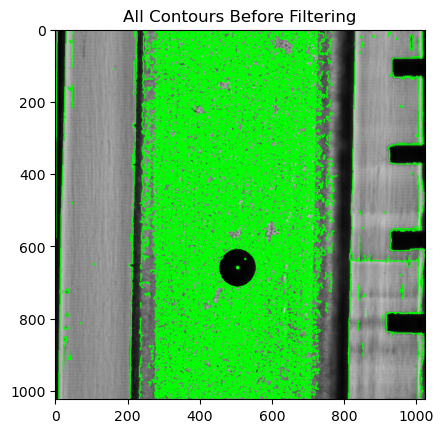

Processing frame 2/1001.0


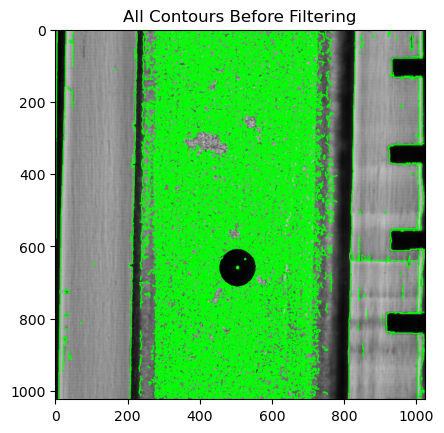

Processing frame 3/1001.0


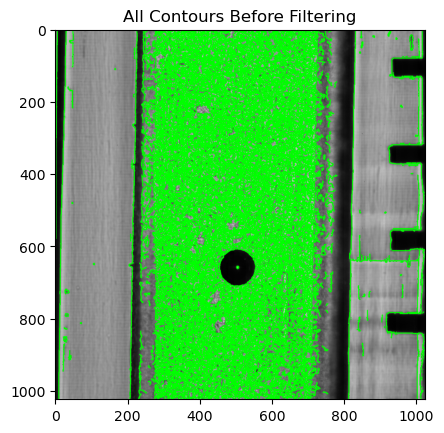

Processing frame 4/1001.0


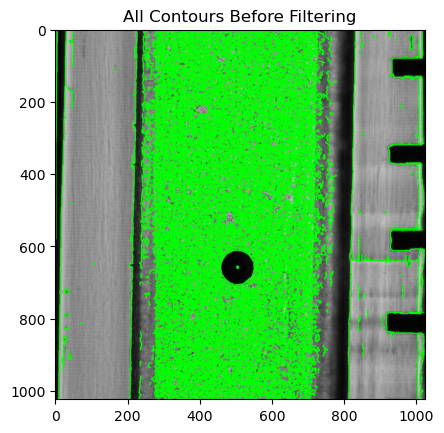

Processing frame 5/1001.0


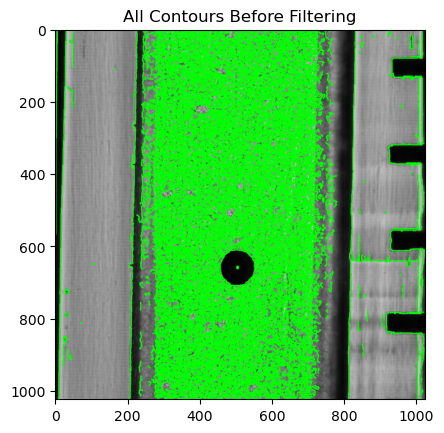

Processing frame 6/1001.0


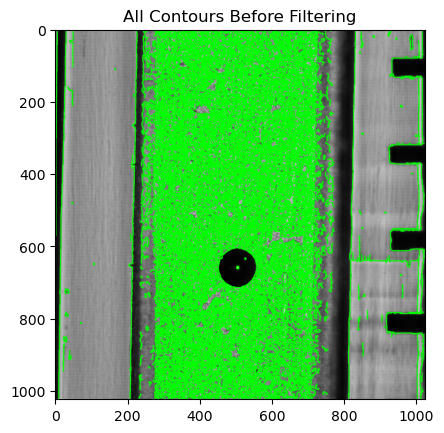

Processing frame 7/1001.0


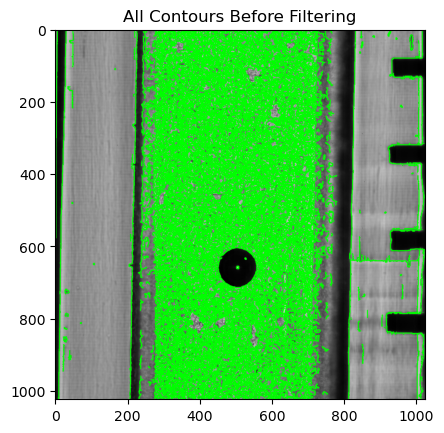

Processing frame 8/1001.0


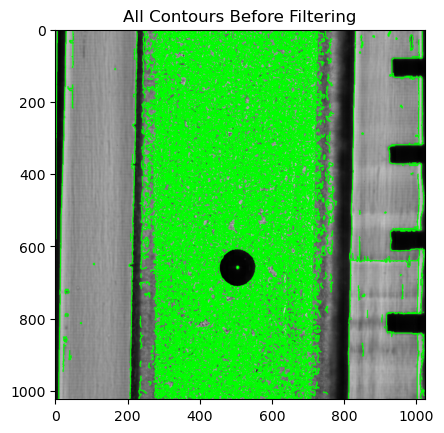

Processing frame 9/1001.0


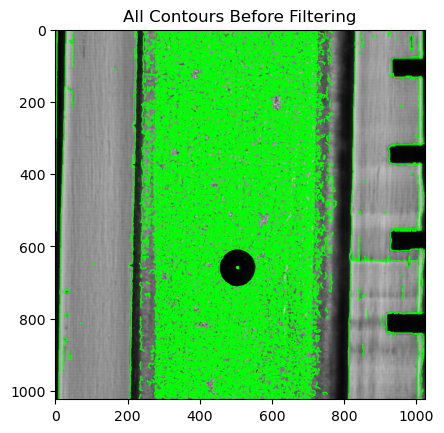

In [5]:
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import pixel_converter
from assemble_frames_with_order_numbers import assemble_frames_with_order_numbers
from table_image_generator import create_table_image, find_min_max_avg_table

def create_directories(base_path, video_base_name, folder_names):
    """動画ごとのディレクトリとサブフォルダを作成する"""
    video_directory = os.path.join(base_path, video_base_name)
    os.makedirs(video_directory, exist_ok=True)
    for folder_name in folder_names:
        os.makedirs(os.path.join(video_directory, folder_name), exist_ok=True)
    return video_directory

def get_video_info(filename):
    """動画の基本情報を取得する"""
    cap = cv2.VideoCapture(filename)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    return width, height, total_frame, fps


def preprocess_frame(frame):
    """フレームの前処理を行う、オーツの方法を使った自動閾値の検出"""
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # オーツの方法を用いて最適なグローバル閾値を見つける
    ret, _ = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # オーツの方法で見つけた閾値を使ってCannyエッジ検出を行う
    # retは適用された閾値
    lower_threshold = int(0.5 * ret)
    upper_threshold = int(ret)

    edges = cv2.Canny(blurred_image, lower_threshold, upper_threshold)
    return edges


def detect_contours(binary):
    """二値画像から輪郭を検出する"""
    # エッジを少し太くする
    # dilated = cv2.dilate(binary, (3, 3), iterations=1)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def draw_and_show_contours(image, contours, title='Contours'):
    """画像に輪郭を描画して表示する関数"""
    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

def filter_contours(contours, conditions):
    """特定の条件に基づいて輪郭をフィルタリングする"""
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if conditions["min_contour_area"] <= area <= conditions["max_contour_area"]:
            filtered_contours.append(contour)
    return filtered_contours

    
# その他の関数（find_reference_point, calculate_angle_from_reference, draw_angle_points）は既に定義されているため省略
def find_reference_point(contour, centroid):
    cx, cy = centroid
    reference_point = None
    min_y = float('inf')  # 最小のy座標値を見つけるために無限大で初期化
    for point in contour:
        x, y = point[0]
        if x == cx and y < cy:  # 重心の真上に位置する点を探す
            if y < min_y:  # より上に位置する点を見つけた場合
                min_y = y
                reference_point = (x, y)
    return reference_point


def calculate_angle_from_reference(contour, centroid, reference_point):
    angles = []
    cx, cy = centroid
    rx, ry = reference_point
    reference_angle = math.degrees(math.atan2(ry - cy, rx - cx))

    for point in contour:
        x, y = point[0]
        angle = math.degrees(math.atan2(y - cy, x - cx)) - reference_angle
        if angle < 0:
            angle += 360
        angles.append(angle)
    return angles

def draw_angle_points(image, contours, angles):
    target_angles = [0, 90, 180, 270]  # 対象とする角度
    colors = [(255, 0, 0), (0, 255, 0), (0, 255, 255), (255, 0, 255)]  # 各角度に対応する色

    for contour, angle_set in zip(contours, angles):
        for target_angle, color in zip(target_angles, colors):
            # 対象の角度に最も近い点を見つける
                        closest_point_index = min(range(len(contour)), key=lambda i: abs(angle_set[i] - target_angle))
                        closest_point = contour[closest_point_index]
                        cv2.circle(image, tuple(closest_point[0]), 5, color, -1)

    return image

def calculate_centroid(contour):
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        return cy  # y座標のみを返す
    else:
        return None

def draw_contours_and_centroid(frame, contours, save_directory):
    for idx, contour in enumerate(contours):
        # 重心の計算
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])

        # 輪郭と重心を描画
        contour_image = frame.copy()
        cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)
        cv2.circle(contour_image, (cx, cy), 5, (0, 0, 255), -1)

        # 描画した画像を保存
        save_path = os.path.join(save_directory, f"contour_centroid_{frame_count}_{idx}.bmp")
        cv2.imwrite(save_path, contour_image)

def draw_and_save_angle_images(frame, contours, angles, save_directory):
    for idx, (contour, angle_set) in enumerate(zip(contours, angles)):
        angle_image = draw_angle_points(frame.copy(), [contour], [angle_set])
        
        # 描画した画像を保存
        save_path = os.path.join(save_directory, f"angle_image_{frame_count}_{idx}.bmp")
        cv2.imwrite(save_path, angle_image)
        
def calculate_vertical_velocity(prev_cy, current_cy, dt):
    if prev_cy is None or current_cy is None:
        return None
    dy = current_cy - prev_cy
    velocity = dy / dt  # 単位はピクセル/秒
    return velocity

def pixel_to_mm(pixel_value, dpi):
    mm_per_inch = 25.4
    mm_value = (pixel_value / dpi) * mm_per_inch
    return mm_value

def calculate_sphere_volume_from_radius(radius):
    # 球の体積を計算
    volume = (4/3) * math.pi * radius**3
    return volume

def process_spherical_bubble(contour):
    # 重心の計算
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
    else:
        # ゼロ除算を避けるための処理
        cx, cy = 0, 0

    # 最大半径の計算
    max_radius = max(math.sqrt((x - cx) ** 2 + (y - cy) ** 2) for x, y in contour[:, 0])

    # 球の体積の計算
    volume = calculate_sphere_volume_from_radius(max_radius)
    return volume

# メイン処理
# filename = "C:\\Users\\flow\\Desktop\\bubbledate\\spherical bubbleGray.mp4"
filename = "C:\\Users\\flow\\Desktop\\今さんデータ\\straightball.mp4"
base_path = "C:\\Users\\flow\\Desktop\\bubble_rasing_result\\"
video_base_name = os.path.splitext(os.path.basename(filename))[0]
folder_names = ["original", "gray", "binary", "contours", "angles"]

# 動画情報の取得
video_directory = create_directories(base_path, video_base_name, folder_names)
width, height, total_frame, fps = get_video_info(filename)
dpi = pixel_converter.get_video_dpi(filename)
# 動画情報の出力
print(f"Video: {filename}")
print(f"Resolution: {width}x{height}")
print(f"Total Frames: {total_frame}")
print(f"FPS: {fps}")
print(f"DPI: {dpi}")
print(f"video_directory:", video_directory)


# 各種画像保存用ディレクトリの作成
directories = {
    "original": os.path.join(video_directory, "original"),
    "gray": os.path.join(video_directory, "gray"),
    "binary": os.path.join(video_directory, "binary"),
    "contours": os.path.join(video_directory, "contours"),
    "angles": os.path.join(video_directory, "angles")
}
for dir_path in directories.values():
    os.makedirs(dir_path, exist_ok=True)
    print(dir_path)

# ビデオ処理
cap = cv2.VideoCapture(filename)
frame_count = 0
test_frame_limit = 10  # テストに使用するフレーム数

while frame_count < test_frame_limit:
    ret, frame = cap.read()
    if not ret:
        break
    print(f"Processing frame {frame_count}/{total_frame}")

    # フレームの前処理
    binary = preprocess_frame(frame)

    # 輪郭検出とフィルタリング
    contours = detect_contours(binary)
    # フィルタリング前の輪郭を描画
    draw_and_show_contours(frame, contours, 'All Contours Before Filtering')
    conditions = {"min_contour_area": 100, "max_contour_area": 1000}
    filtered_contours = filter_contours(contours, conditions)
    
    # オリジナル、グレースケール、二値化画像の保存
    cv2.imwrite(os.path.join(directories["original"], f"frame_{frame_count}.bmp"), frame)
    cv2.imwrite(os.path.join(directories["gray"], f"frame_{frame_count}.bmp"), cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
    cv2.imwrite(os.path.join(directories["binary"], f"frame_{frame_count}.bmp"), binary)
    
    # # 角度計算と描画
    # for contour in filtered_contours:
    #     M = cv2.moments(contour)
    #     if M["m00"] != 0:
    #         cx = int(M["m10"] / M["m00"])
    #         cy = int(M["m01"] / M["m00"])
    #         reference_point = find_reference_point(contour, (cx, cy))
    #         angles = calculate_angle_from_reference(contour, (cx, cy), reference_point)
            
    #         draw_and_save_angle_images(frame, [contour], [angles], directories["angles"])
    #         draw_contours_and_centroid(frame, [contour], directories["contours"])
        
        
    
    frame_count += 1

cap.release()




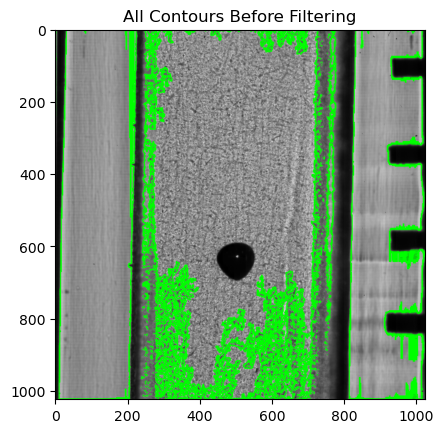

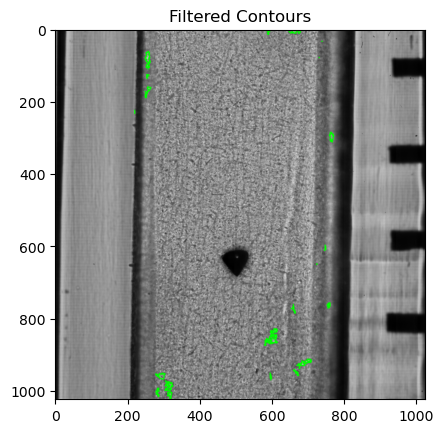

In [10]:
import cv2
import numpy as np

def filter_contours_by_shape(contours, approx_poly_edges=3, angle_threshold=20):
    """
    輪郭リストを受け取り、指定された形状（ここでは三角形）に基づいてフィルタリングする関数。
    
    Parameters:
    contours: 輪郭リスト
    approx_poly_edges: 近似する辺の数
    angle_threshold: 検出する角度の閾値
    
    Returns:
    filtered_contours: フィルタリングされた輪郭リスト
    """
    filtered_contours = []
    for contour in contours:
        # 輪郭を近似する
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.04 * peri, True)
        
        # 近似した辺の数が指定された数と等しいか
        if len(approx) == approx_poly_edges:
            # ここでは角度をチェックしていませんが、必要であれば角度をチェックする処理を追加
            filtered_contours.append(contour)
    return filtered_contours

def filter_contours_by_area(contours, min_area=1000, max_area=10000):
    """
    輪郭リストを受け取り、指定された面積の範囲に基づいてフィルタリングする関数。
    
    Parameters:
    contours: 輪郭リスト
    min_area: 最小面積の閾値
    max_area: 最大面積の閾値
    
    Returns:
    filtered_contours: フィルタリングされた輪郭リスト
    """
    filtered_contours = [cnt for cnt in contours if min_area < cv2.contourArea(cnt) < max_area]
    return filtered_contours

# サンプル画像を読み込む
image = cv2.imread('C:\\Users\\flow\\Desktop\\bubble_rasing_result\\tetrahedron\\gray\\frame_0.bmp')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# すべての輪郭を描画して確認する前に画像をコピー
all_contours_image = frame.copy()
cv2.drawContours(all_contours_image, contours, -1, (0, 255, 0), 2)

# matplotlibを使用してすべての輪郭が描画された画像を表示する
plt.imshow(cv2.cvtColor(all_contours_image, cv2.COLOR_BGR2RGB))  # BGRからRGBに変換
plt.title('All Contours Before Filtering')
plt.show()

# # 輪郭をフィルタリングする
# filtered_contours = filter_contours_by_shape(contours, approx_poly_edges=3, angle_threshold=20)
# # filtered_contours = filter_contours_by_area(filtered_contours, min_area=1000, max_area=5000)

# # フィルタリングされた輪郭を画像に描画する
# for contour in filtered_contours:
#     cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)

# # matplotlibを使用して画像を表示する
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # BGRからRGBに変換
# plt.title('Filtered Contours')
# plt.show()


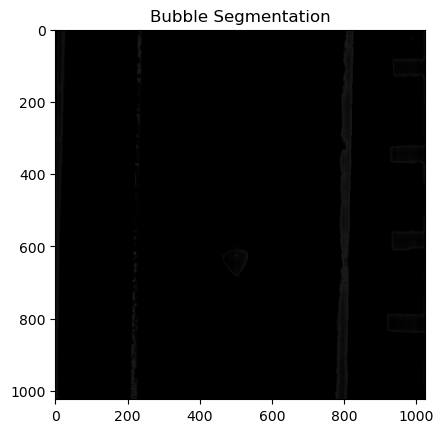

In [11]:
# カラー画像を読み込む
image = cv2.imread('C:\\Users\\flow\\Desktop\\bubble_rasing_result\\tetrahedron\\gray\\frame_0.bmp')

# BGRからHSV色空間に変換する
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# 気泡の色に基づいてHSV値の閾値を設定する
# これは調整が必要です
lower_hsv = np.array([0, 0, 0])
upper_hsv = np.array([180, 255, 30])

# 色閾値を用いてバイナリマスクを作成する
mask = cv2.inRange(hsv, lower_hsv, upper_hsv)

# マスクを元の画像に適用する
segmented = cv2.bitwise_and(image, image, mask=mask)

# 結果を表示する
plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
plt.title('Bubble Segmentation')
plt.show()

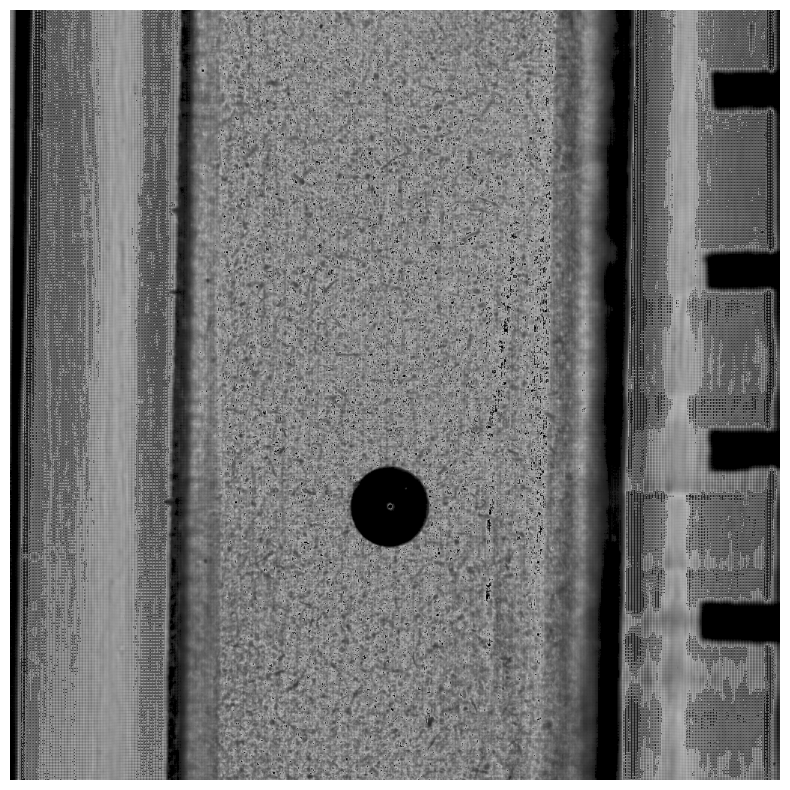

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# コールバック関数（使用しない場合でも定義が必要）
def nothing(x):
    pass

# ウィンドウの作成
cv2.namedWindow('Trackbars')

# トラックバーの作成
cv2.createTrackbar('H Lower','Trackbars',0,179,nothing) # 色相の下限
cv2.createTrackbar('H Upper','Trackbars',179,179,nothing) # 色相の上限
cv2.createTrackbar('S Lower','Trackbars',0,255,nothing) # 彩度の下限
cv2.createTrackbar('S Upper','Trackbars',255,255,nothing) # 彩度の上限
cv2.createTrackbar('V Lower','Trackbars',0,255,nothing) # 明度の下限
cv2.createTrackbar('V Upper','Trackbars',255,255,nothing) # 明度の上限

# 画像表示用のウィンドウを作成
cv2.namedWindow('Image')

# 画像の読み込み
frame = cv2.imread('C:\\Users\\flow\\Desktop\\bubble_rasing_result\\straightball\\original\\frame_0.bmp')

# HSVに変換
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

while True:
    # トラックバーから閾値を取得
    h_lower = cv2.getTrackbarPos('H Lower','Trackbars')
    h_upper = cv2.getTrackbarPos('H Upper','Trackbars')
    s_lower = cv2.getTrackbarPos('S Lower','Trackbars')
    s_upper = cv2.getTrackbarPos('S Upper','Trackbars')
    v_lower = cv2.getTrackbarPos('V Lower','Trackbars')
    v_upper = cv2.getTrackbarPos('V Upper','Trackbars')
    
    # 閾値に基づくマスクの作成
    lower_bound = np.array([h_lower, s_lower, v_lower])
    upper_bound = np.array([h_upper, s_upper, v_upper])
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # マスクの適用
    result = cv2.bitwise_and(frame, frame, mask=mask)

    # 結果の表示
    cv2.imshow('Image', result)

    # 'q'キーが押されたら終了
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
masked_image = cv2.bitwise_and(frame, frame, mask=mask)

# 元の画像を読み込む
original_image = cv2.imread('C:\\Users\\flow\\Desktop\\bubble_rasing_result\\tetrahedron\\gray\\frame_0.bmp')

# 結果が空でないことを確認してから表示する
if masked_image is not None:
    # 結果をmatplotlibで表示する
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))  # BGRからRGBに変換
    plt.axis('off')  # 軸をオフにする
    plt.show()
else:
    print("マスキング処理に失敗しました。")

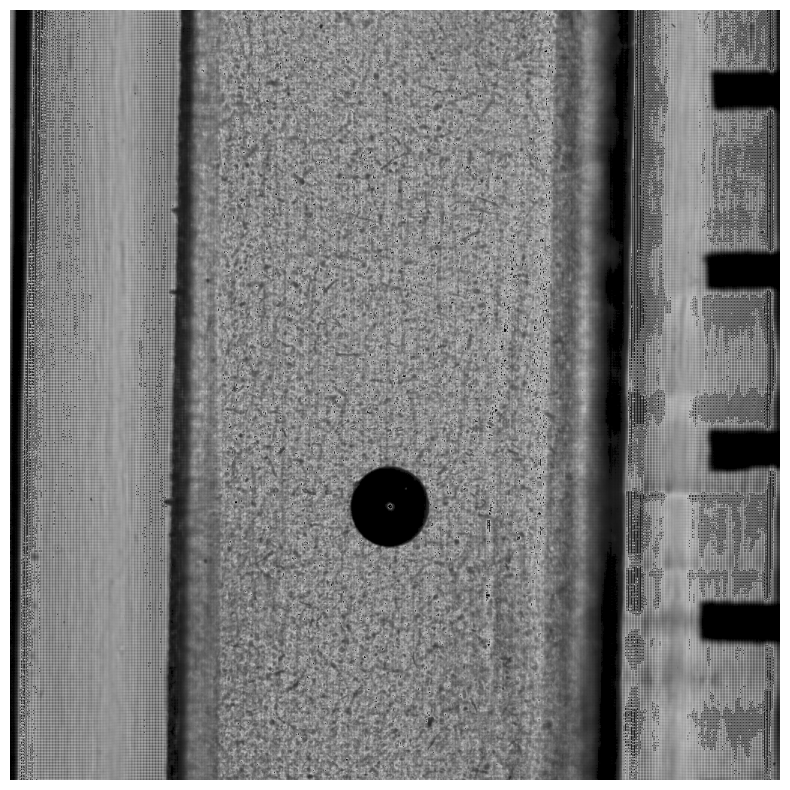

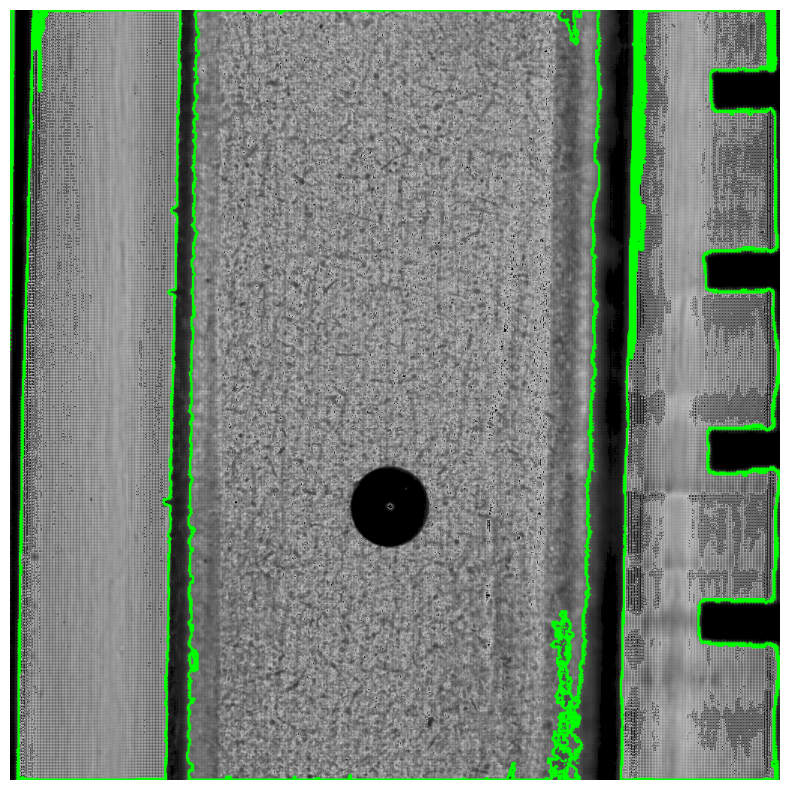

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_hsv_masking(image_path, lower_bound, upper_bound):
    # 画像の読み込み
    frame = cv2.imread(image_path)

    # HSVに変換
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # マスクの作成
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # マスクの適用
    masked_image = cv2.bitwise_and(frame, frame, mask=mask)
    return masked_image

def adjust_hsv_thresholds(image_path):
    def nothing(x):
        pass

    # ウィンドウの作成
    cv2.namedWindow('Trackbars')

    # トラックバーの作成
    cv2.createTrackbar('H Lower', 'Trackbars', 0, 179, nothing)
    cv2.createTrackbar('H Upper', 'Trackbars', 179, 179, nothing)
    cv2.createTrackbar('S Lower', 'Trackbars', 0, 255, nothing)
    cv2.createTrackbar('S Upper', 'Trackbars', 255, 255, nothing)
    cv2.createTrackbar('V Lower', 'Trackbars', 0, 255, nothing)
    cv2.createTrackbar('V Upper', 'Trackbars', 255, 255, nothing)

    # 画像の読み込み
    frame = cv2.imread(image_path)

    # HSVに変換
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    while True:
        # トラックバーから閾値を取得
        h_lower = cv2.getTrackbarPos('H Lower', 'Trackbars')
        h_upper = cv2.getTrackbarPos('H Upper', 'Trackbars')
        s_lower = cv2.getTrackbarPos('S Lower', 'Trackbars')
        s_upper = cv2.getTrackbarPos('S Upper', 'Trackbars')
        v_lower = cv2.getTrackbarPos('V Lower', 'Trackbars')
        v_upper = cv2.getTrackbarPos('V Upper', 'Trackbars')

        # 閾値に基づくマスクの作成
        lower_bound = np.array([h_lower, s_lower, v_lower])
        upper_bound = np.array([h_upper, s_upper, v_upper])
        mask = cv2.inRange(hsv, lower_bound, upper_bound)

        # マスクの適用
        result = cv2.bitwise_and(frame, frame, mask=mask)

        # 結果の表示
        cv2.imshow('Image', result)

        # 'q'キーが押されたら終了
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

    return lower_bound, upper_bound

def detect_contours(masked_image):
    """
    マスク化された画像から輪郭を検出する関数。
    
    :param masked_image: マスク化された画像
    :return: 検出された輪郭のリスト
    """
    # マスク化された画像をグレースケールに変換（必要に応じて）
    gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    # 二値化
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 輪郭検出
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours


# 使用例
image_path = 'C:\\Users\\flow\\Desktop\\bubble_rasing_result\\straightball\\original\\frame_0.bmp'
lower_bound, upper_bound = adjust_hsv_thresholds(image_path)
masked_image = apply_hsv_masking(image_path, lower_bound, upper_bound)

# 結果の表示
if masked_image is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("マスキング処理に失敗しました。")
    
    
# 輪郭を検出する
contours = detect_contours(masked_image)

# 輪郭を描画するための元画像のコピーを作成
contour_image = masked_image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)


# 結果をmatplotlibで表示
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Lower Threshold: 126
Upper Threshold: 255


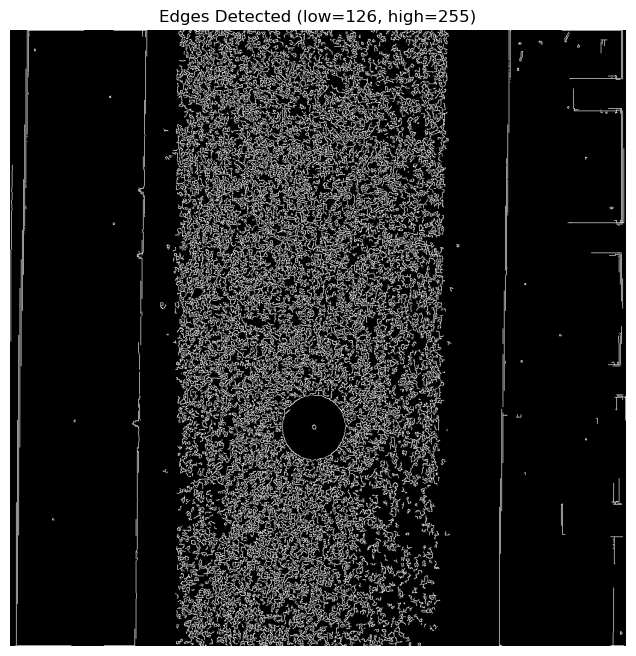

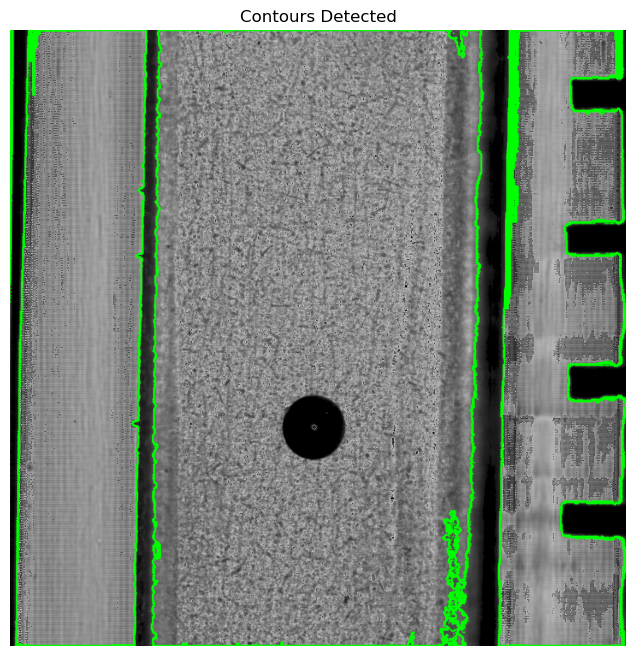

In [15]:
import cv2
import numpy as np

def nothing(x):
    pass

def canny_edge_detector(image_path):
    # ウィンドウの作成
    cv2.namedWindow('Canny Edges')

    # トラックバーの作成
    cv2.createTrackbar('Lower Threshold', 'Canny Edges', 0, 255, nothing)
    cv2.createTrackbar('Upper Threshold', 'Canny Edges', 0, 255, nothing)

    # 画像の読み込み（グレースケール）
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    while True:
        # トラックバーの現在の位置を取得
        lower_threshold = cv2.getTrackbarPos('Lower Threshold', 'Canny Edges')
        upper_threshold = cv2.getTrackbarPos('Upper Threshold', 'Canny Edges')

        # Cannyエッジ検出を適用
        edges = cv2.Canny(image, lower_threshold, upper_threshold)

        # 結果の表示
        cv2.imshow('Canny Edges', edges)

        # 'q'キーを押すとループから抜ける
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
    # ウィンドウの破棄
    cv2.destroyAllWindows()
    # 閾値を出力
    print(f'Lower Threshold: {lower_threshold}')
    print(f'Upper Threshold: {upper_threshold}')
    return edges, lower_threshold, upper_threshold


# 輪郭検出を行う関数
def detect_contours(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# この関数を実行するためには、実際の画像パスを指定する必要があります。
image_path = 'C:\\Users\\flow\\Desktop\\bubble_rasing_result\\straightball\\original\\frame_0.bmp'
edges, low_threshold, high_threshold = canny_edge_detector(image_path)
# 結果を表示
plt.figure(figsize=(8, 8))
plt.imshow(edges, cmap='gray')
plt.title(f'Edges Detected (low={low_threshold}, high={high_threshold})')
plt.axis('off')
plt.show()

# 輪郭検出
contours = detect_contours(edges)

# 元の画像を読み込む
original_image = cv2.imread(image_path)

# 結果を表示する
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title('Contours Detected')
plt.axis('off')
plt.show()
